# Data analysis

## Imports and loading all data sets



In [6]:
import os
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

try:
  print("Path to Thesis =", ptt)
except:
  if "drive" in os.listdir():
    print("Working on GDrive.")
    ptt = ""
    %cd /content/drive/My\ Drive/Thesis/
  else:
    print("Working on local device.")
    ptt = os.path.expanduser("~/thesis")
    print("pathToThesis =", ptt)

from NN_train_util import *
from util import *

%load_ext autoreload
%autoreload 1
%aimport NNDataLoader
%aimport NN_train_util
%aimport util


Tc0 = 0.894
train_on_vortex = False
T_range = np.linspace(0.1, 3.0, num=64) # T_range when data is generated for data set


# can change these
train_on_vortex = False
L_range = [8,16,24,32,40,48,56,64] # [8,16,24,32,40,48,56,64]

Path to Thesis = 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from __future__ import division
from scipy.optimize import curve_fit
from numpy import log as ln

def filter_unique_calcMean(ts, obs):
    """returns mean obs for every unique t value in ts

    Args:
        ts (np.array): list of ts, corresponding with obs
        obs (np.array): list of obs, corresponding with ts

    Returns:
        unique_ts: np array of unique ts in ts
        mean_obs: mean obs value of all obs values of every unique t in ts
    """
    unique_ts, indices = np.unique(ts, return_inverse=True)
    mean_obs = np.zeros_like(unique_ts)
    for i, t in enumerate(unique_ts):
        idx = np.where(ts == t)
        obs_t =obs[idx]
        mean_obs[i] = obs_t.mean()
    return unique_ts, mean_obs

# https://stackoverflow.com/questions/46909373/how-to-find-the-exact-intersection-of-a-curve-as-np-array-with-y-0/46911822#46911822
def find_roots(x, y):
    s = np.abs(np.diff(np.sign(y))).astype(bool)
    return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)

def universal_jump_estimate(T):
  return T * (2/np.pi)

def scaling_relation(L, a, b): 
  return a + b / (ln(L)**2)

In [8]:
if True:
  # loadind data
  data = {L: load_data_from_pickle(L, Tc0, pathToThesis=ptt, trainSet=True, train_on_vortex=train_on_vortex, device="cpu") for L in L_range}

  test = data[8].labels.histc()
  print(test[[0,-1]])
  18/64,46/64

tensor([18000., 46000.])


## Some configs

In [30]:
vortices = data[L].get_vortex_from_spin()

vortex from spin device: cpu


shape torch.Size([64000, 32, 32])
min, max 5.792314823338529e-07 6.2831854820251465
normalized? False
T = 1.2968254089355469
AxesImage(31.25,31.25;193.75x188.75)
test


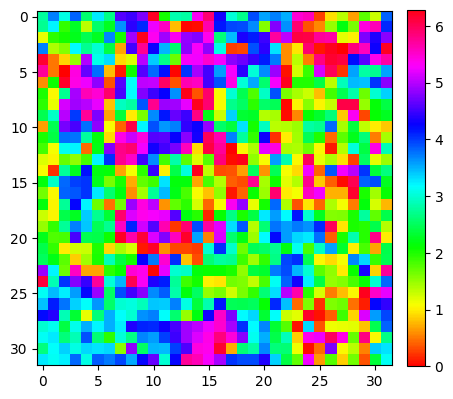

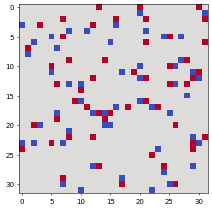

In [96]:
from matplotlib import cm
from matplotlib.colors import Normalize
L = 32
good_id = False
i = 0
while not good_id:
  config_idx = np.random.randint(0, high=len(data[L]))
  T = data[L].Ts.cpu()[config_idx].item()
  
  if 1.1 < T < 1.5:
    good_id = True
  i += 1

  if i > 5000:
    raise FileNotFoundError("no good id found in 5000 tries")
  
  
  
  
config = data[L].configs[config_idx].cpu().numpy()
print("shape", data[L].configs.shape)
print("min, max", torch.min(data[L].configs).item(), 
        torch.max(data[L].configs).item())
print("normalized?", data[L].normalized_data)
print("T =", T)
fig, ax = plt.subplots(dpi=100, figsize=(5,5))

pos = ax.imshow(config, cmap=cm.get_cmap('hsv'), norm=Normalize(0, 2*np.pi))
fig.colorbar(pos, ax=ax, fraction=0.046, pad=0.04)

fig2, ax2 = plt.subplots(dpi=50, figsize=(5,5))

print(ax2.imshow(vortices[config_idx][0].cpu().numpy(), 
                 cmap=cm.get_cmap('coolwarm'), norm=Normalize(-1,1)))
print("test")
#plotXYGrid_colorbar(config, fig=fig, ax=ax)

## Data set analysis

Section in which we convince ourselves that our current data set is valid and 
has the expected characteristics. 

This section includes:
 
* Observables analysis (E, M, X, Cv)


## $T_c$ from spin stiffness and universal jump
Takes a while longer to calc. than magnetization. See thesis folder for saved calculations for all Ls **EXCEPT L=40**.

(64000,)
64000 64000


(0.0, 1.0)

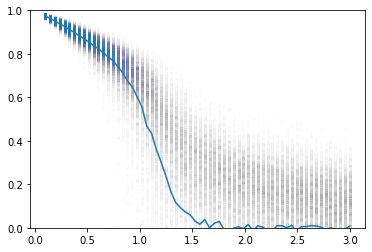

In [ ]:
# spin stiffness
L=8
plt.scatter(data[L].Ts.numpy(), ss, marker=".", alpha=.005)
plt.plot(*filter_unique_calcMean(data[L].Ts.numpy(), ss))
plt.ylim(0,1)

In [ ]:
# calculating when spin stiffness crosses the expected universal jump line

print(L_range) # NOT DONE FOR L=40
Tc_scaled = np.zeros(len(L_range))
for L_i, L in tqdm(enumerate(L_range), total=len(L_range)):
  ss = np.array([calcSpin_stiffness_y_direction(data[L].configs[i,:,:].numpy(), data[L].Ts[i].item()) for i in range(len(data[L]))])
  uniq_ts, means = filter_unique_calcMean(data[L].Ts.numpy(), ss)
  Tc_scaled[L_i] = find_roots(uniq_ts, means - universal_jump_estimate(uniq_ts)).item()
#np.save("Tc_scaled_fromStiffness.npy", Tc_scaled)

[8, 16, 24, 32, 48, 56, 64]


100%|██████████| 7/7 [49:28<00:00, 424.04s/it]


Tc = 0.8982214876275002 +/- 0.0019604205912924404


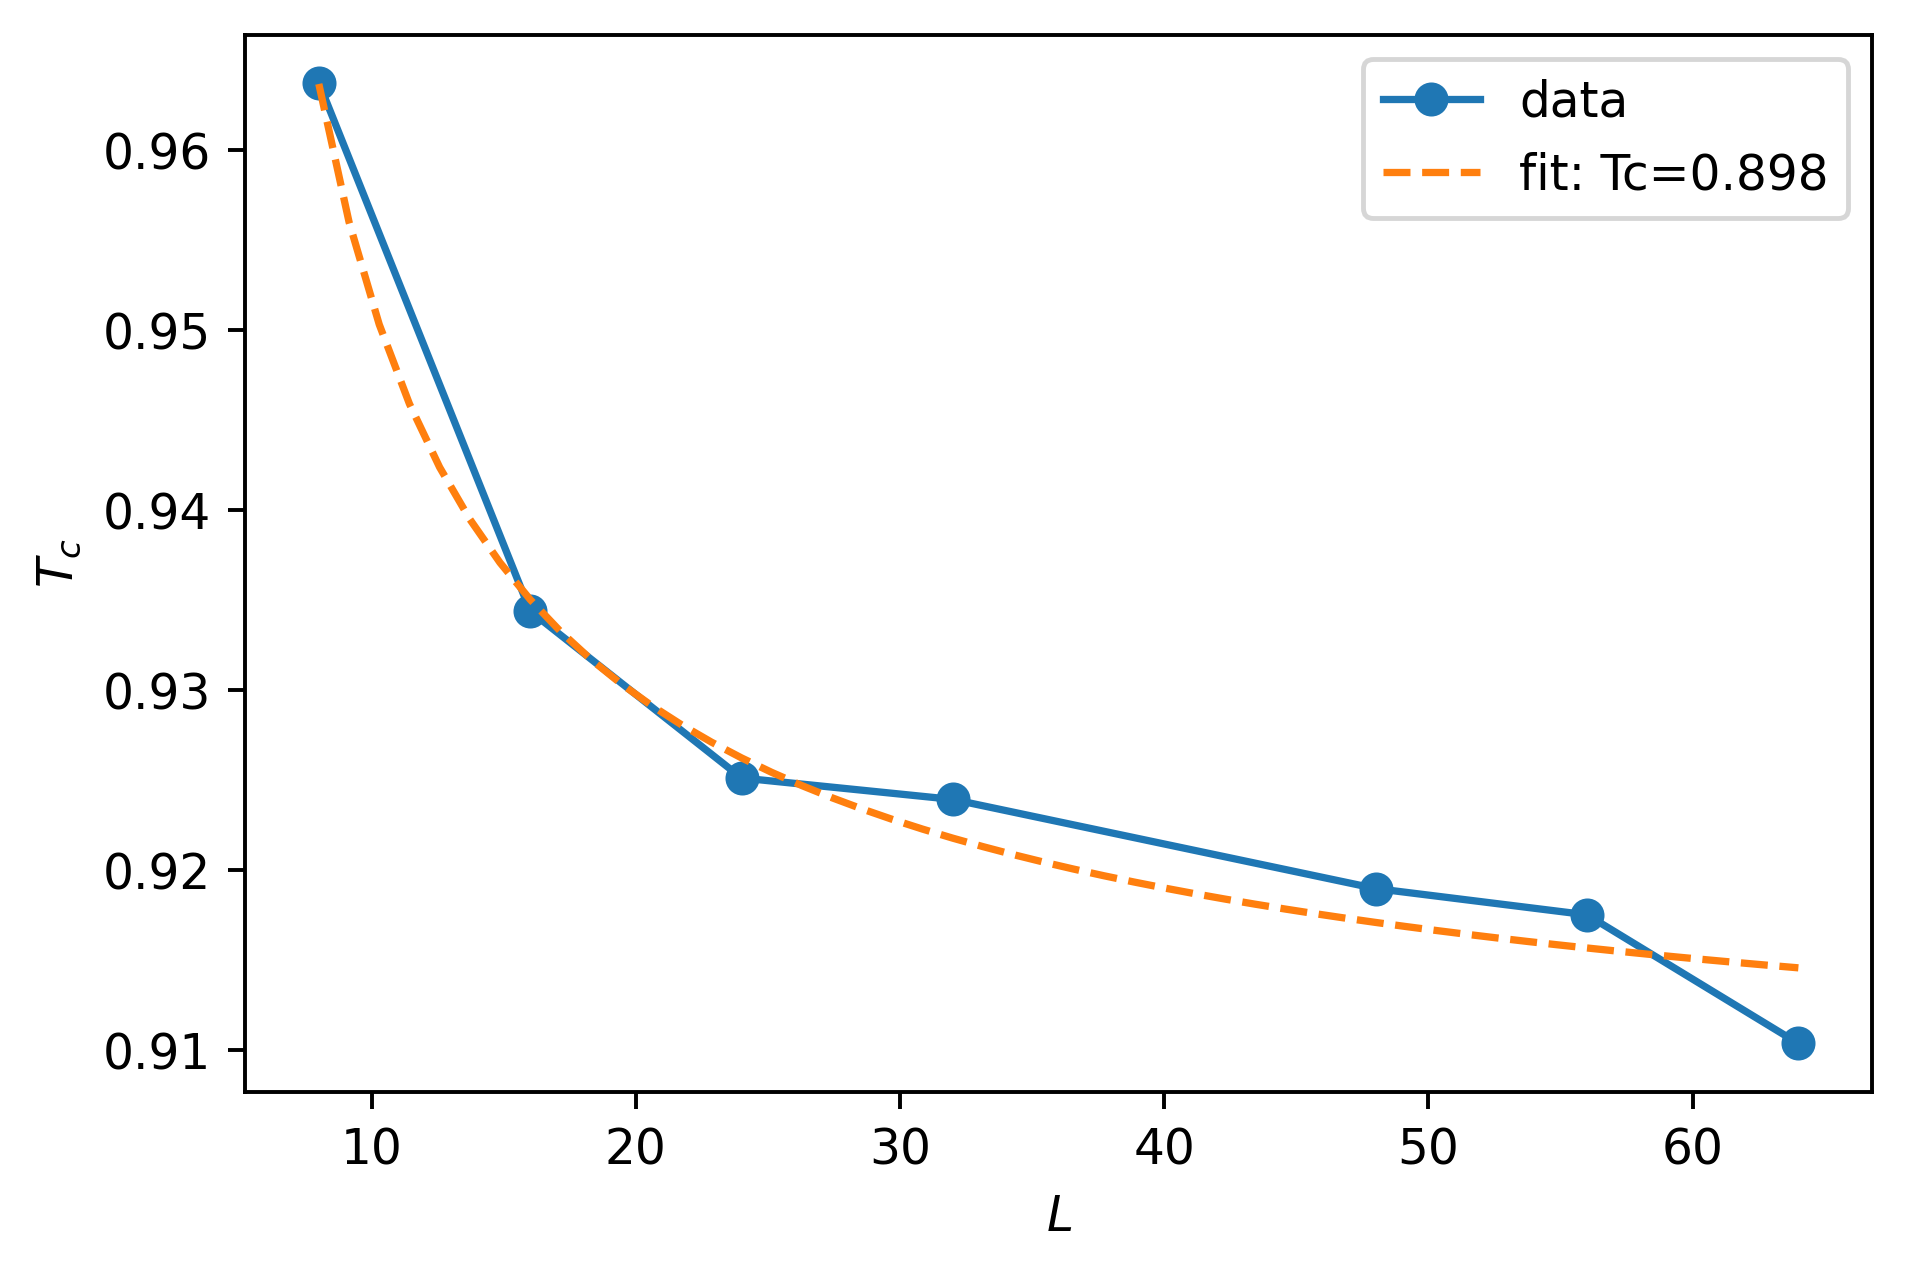

In [ ]:
# fitting

xdata = L_range
xdata_plot = xdata
xdata_fit = np.linspace(8,64)

ydata = Tc_scaled
fig, ax = plt.subplots(dpi=350)
ax.plot(xdata_plot, ydata, '-', label='data', marker="o")

popt, pcov = curve_fit(scaling_relation, xdata, ydata)

ax.plot(xdata_fit, scaling_relation(xdata_fit, *popt), '--',
         label='fit: Tc=%5.3f' % tuple(popt)[0])
ax.legend()
ax.set_ylabel("$T_c$")
ax.set_xlabel("$L$")

Tc = popt[0]
dev = np.sqrt(pcov[0,0])
print("Tc =", Tc, "+/-", dev)

## $M$ at $T_c$

In [ ]:
# calculate M
L_range = np.array(L_range)
M = dict()
for L in tqdm(L_range):
  M[L] = np.array([calcMagnetization(cfg)/L**2 for cfg in data[L].configs.numpy()])

100%|██████████| 8/8 [00:18<00:00,  2.36s/it]


100%|██████████| 8/8 [00:00<00:00, 482.85it/s]


Text(0.5, 1.0, 'Magnetic ~failure~')

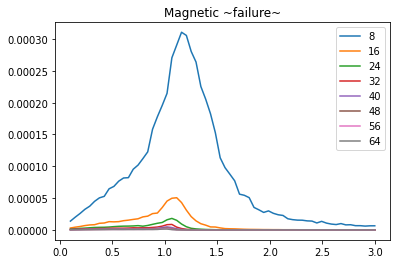

In [ ]:
# magnetic susceptibility
susc = dict()

for L in tqdm(L_range, total=len(L_range)):
  susc[L] = np.zeros(64)

  # copied from 'filter_unique_calcMean'
  ts = data[L].Ts.cpu().numpy()
  unique_ts, indices = np.unique(ts, return_inverse=True)
  for t_i, t in enumerate(unique_ts):
    idx = np.where(ts == t)
    mag = M[L][idx]
    N = len(mag)
    susc[L][t_i] = (np.dot(mag, mag)/N - (np.sum(mag)/N)**2) / (L**2 * t)

# plot susc
for L in tqdm(L_range):
  plt.plot(unique_ts, susc[L], label=L)
plt.legend()
plt.title("Magnetic ~failure~")

100%|██████████| 8/8 [00:00<00:00, 86.36it/s]


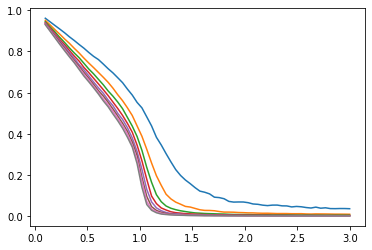

In [ ]:
# calculate M at Tc for all L
Tc = 0.894
M_at_Tc = np.zeros(len(L_range))
i = 0
for L in tqdm(L_range):
  uniq_ts, means = filter_unique_calcMean(data[L].Ts.numpy(), M[L])
  plt.plot(uniq_ts, means)
  M_at_Tc[i] = np.interp(Tc, uniq_ts, means)
  
  i += 1

R2 0.9987671148547843
[ 1.39979174 -0.42814318] [[ 0.00040312 -0.00025309]
 [-0.00025309  0.00016004]]


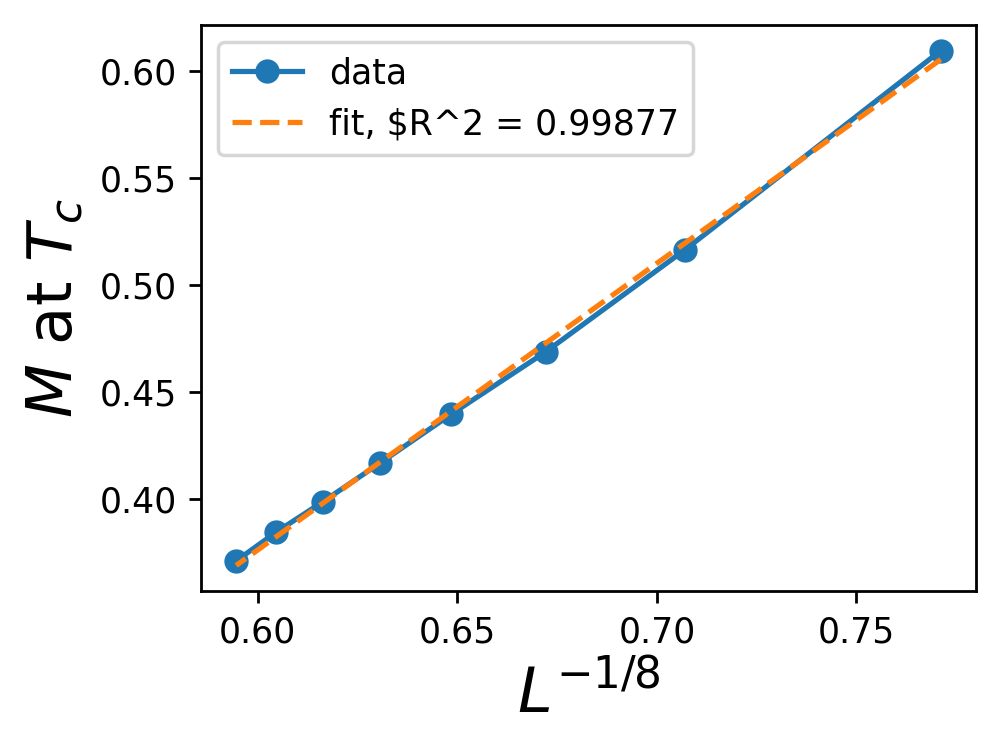

In [ ]:
# plot scaling relation
from sklearn.metrics import r2_score

# fits
def scaling_M_at_Tc(L, a, b):
  return a * L**(-0.125) + b

def scaling2_M_at_Tc(L, a, b):
  return a*(2* L**2)**(-0.0625) +b  

def true_at_Tc(L):
  return (2*L**2)**(-1/16)

xdata = L_range
xx = np.linspace(np.min(L_range), np.max(L_range))
ydata = M_at_Tc

popt, pcov = curve_fit(scaling2_M_at_Tc, xdata, ydata)


popt, pcov = curve_fit(scaling2_M_at_Tc, xdata, ydata)
y_pred = scaling2_M_at_Tc(xdata, *popt)
R2 = r2_score(ydata, y_pred)
print("R2", R2)


# plots
fig, ax = plt.subplots(1,1, dpi=250,figsize=(4,3))
ax.plot(np.array(L_range)**(-0.125), M_at_Tc, marker="o", label="data")

ax.plot(xx**(-0.125), scaling2_M_at_Tc(xx, *popt), "--", label=f'fit, $R^2 = {R2:.5f}') # label='fit: M = %5.3f L^{-1/8} + %5.3f' % tuple(popt)

ax.set_ylabel("$M$ at $T_c$", fontsize=18) # , fontsize=18
ax.set_xlabel('$L^{-1/8}$', fontsize=18) # , fontsize=18
ax.legend()
print(popt, pcov)



## Intermediate vortex layer distribution
See visualization of trained models.
Loading data first.

Then visualising bla.

vortex from spin device: cpu


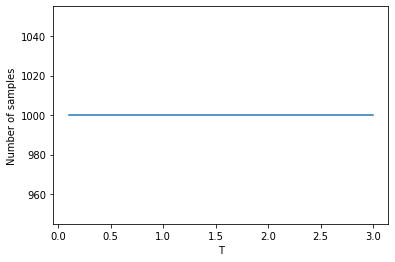

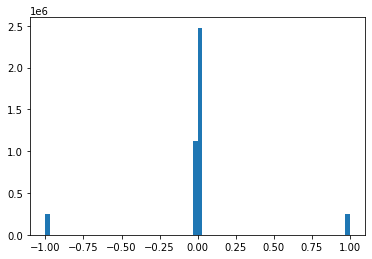

In [ ]:
L=8
fig, ax = plt.subplots()
data[L].plot_T_distribution(ax)
v = data[L].get_vortex_from_spin()
plot_torch_distr(v)

vortex from spin device: cpu
-1/+1: 247831.0  or 0.061
vortex from spin device: cpu
-1/+1: 1008210.0  or 0.062
vortex from spin device: cpu
-1/+1: 2273661.0  or 0.062
vortex from spin device: cpu
-1/+1: 4036327.0  or 0.062
vortex from spin device: cpu
-1/+1: 6299388.0  or 0.079
vortex from spin device: cpu
-1/+1: 9089050.0  or 0.106
vortex from spin device: cpu
-1/+1: 12385743.0  or 0.134
vortex from spin device: cpu
-1/+1: 16164149.0  or 0.161


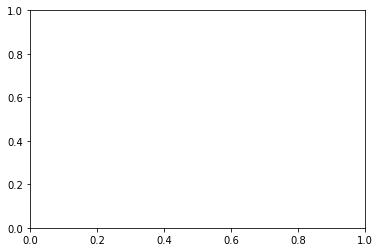

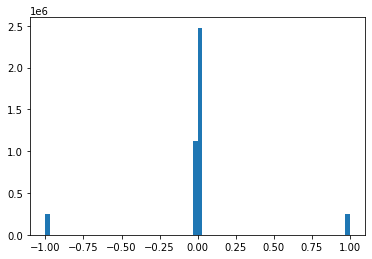

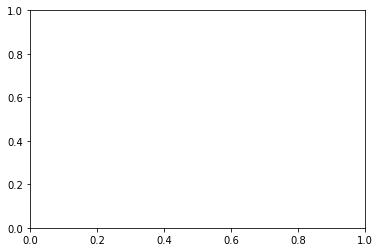

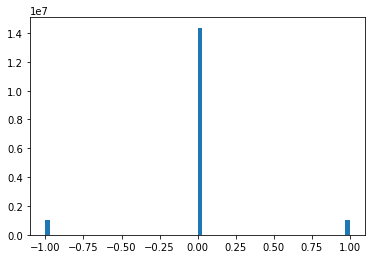

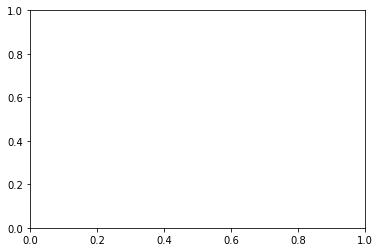

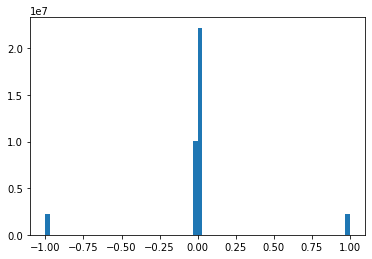

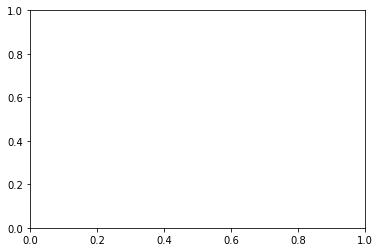

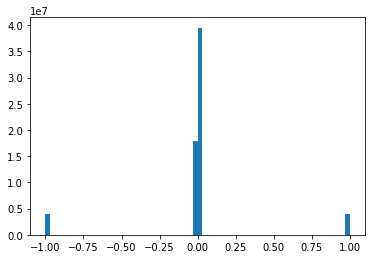

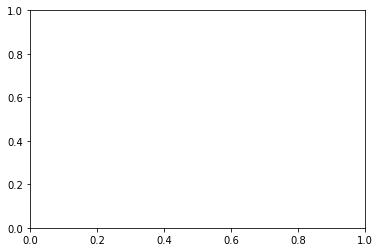

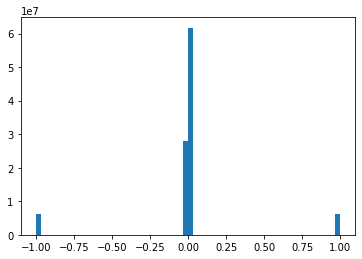

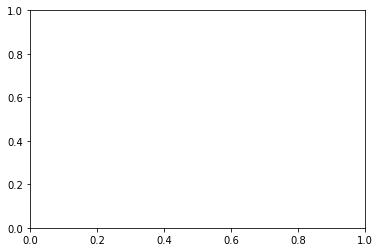

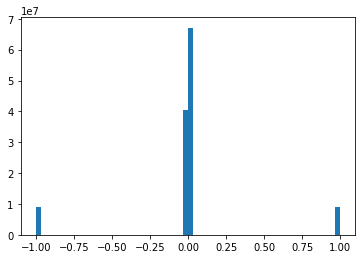

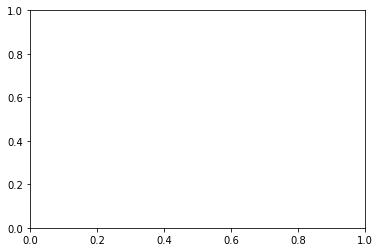

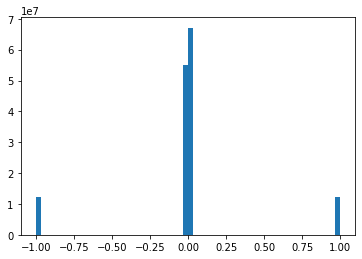

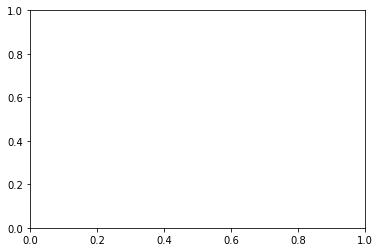

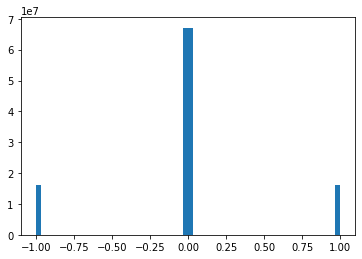

In [ ]:
nonzerofract = []
for L in L_range:
  data = load_data_from_pickle(L, Tc0, pathToThesis=ptt, trainSet=True, train_on_vortex=train_on_vortex, device="cpu")
  fig, ax = plt.subplots()
  v = data.get_vortex_from_spin()
  plot_torch_distr(v)
  negvort = v.histc()[0]

  total = v.histc().sum()
  print(f"-1/+1: {negvort}  or {negvort/total:.3f}")
  nonzerofract.append(negvort*2/total) # x2 for pos and neg values

Text(0, 0.5, '% of values nonzero')

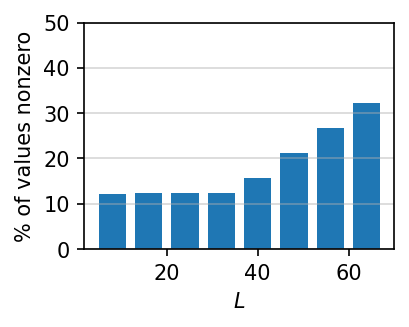

In [ ]:
L_range= np.array(L_range)

fig, ax = plt.subplots(figsize=(4*2/3,3*2/3), dpi=150)
ax.grid(axis="y",zorder=1, alpha=.5)
ax.bar(L_range, np.array(nonzerofract)*100, width=6, zorder=0, alpha=1)
ax.set_ylim(0,50)
ax.set_xlabel("$L$")
ax.set_ylabel("% of values nonzero")


In [ ]:
NUM_BINS = 25
VORTMIN = -1-.04
VORTMAX = 1+.04
train_on_vortex = True

def returnConfigsOfT(dataset, T):
  """Dataset is one dataset containing data for 1 L.
  Filters configs of certain temperature T."""
  if T not in dataset.Ts:
    print(f"invalid T, no matches in dataset with T={T}.")
    print("valid Ts:", dataset.Ts.unique())
    return
  
  return dataset.configs[ [ i for i in range(len(dataset)) if dataset.Ts[i] == T ] ]

def plotHist_LT(ax, L, T, num_bins=NUM_BINS, vortmin=VORTMIN, vortmax=VORTMAX):
  """Plots histogram of configs of certain L & T, 
  makes sense when train_on_vortex ?= True."""
  print(f"Plotting hist of {'vortices' if train_on_vortex else 'spin angles'}")
  histWeights = np.zeros(num_bins)
  configs = returnConfigsOfT(data[L], T).cpu()
  histWeights = configs.histc(bins=num_bins, min=vortmin, max=vortmax)
  ax.hist(np.linspace(vortmin, vortmax, num_bins), bins=num_bins, weights=histWeights, 
    label=f"L={L}, T={T}", alpha=.5, density=True)
  ax.set_title(f"Histogram of {'vortices' if train_on_vortex else 'spin angles'}")

def plotHist_L(ax, L, num_bins=NUM_BINS, vortmin=VORTMIN, vortmax=VORTMAX):
  histWeights = np.zeros(num_bins)
  configs = data[L].configs.cpu()
  histWeights = configs.histc(bins=num_bins, min=vortmin, max=vortmax)
  ax.hist(np.linspace(vortmin, vortmax, num_bins), bins=num_bins, weights=histWeights, 
    label=f"L={L}", alpha=.5, density=True)


In [ ]:
fig, ax = plt.subplots(dpi=100)

plotHist_LT(ax, 16, 0.1)
plotHist_LT(ax, 16, 0.84)
plotHist_LT(ax, 16, 3.0)

ax.set_xlabel("(local) Vorticity")
ax.set_ylabel("Occurence")
ax.legend()


In [ ]:
# decent plot
fig, axs = plt.subplots(1,2)

plotHist_L(axs[0], 16)
plotHist_L(axs[1], 64)
